In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

import lagrangian_optim as lgopt
from scipy import optimize as sp_optimize

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR

### Generate data from Normal Means model

Sample $\mathbf{b}$ from a mixture of Gaussians, and sample $\mathbf{y}$ from the multivariate Gaussian $N_n(\mathbf{b}, \mathbb{I}_n)$, where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

$\mathbf{b} \sim \sum_{k = 1}^{K}w_k N(0, \sigma_k^2)$

$\mathbf{y} \sim N_n(\mathbf{b}, \mathbb{I}_n)$,

where $n$ is the number of samples.
The posterior probability $\hat{q}(\mathbf{b} \mid \mathbf{y}, w_1, \ldots, w_K, \sigma_1, \ldots, \sigma_K)$ is obtained analytically (using Eq. 26 and 27 of [this document](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521)).
We also calculate the posterior mean $\mathbf{b}^{*} \triangleq \mathbb{E}_{\hat{q}}[\mathbf{b}]$.

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
p = 500
k = 4
sparsity = 0.8
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity, scale = 10.0)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
print ("Standard deviation of prior mixture components:")
print (sk)

dj = np.ones(p)
nmash = NormalMeansASHScaled(y, strue, wtrue, sk, d = dj)
qphi, qmu, qvar = nmash.posterior()

bpostmean = np.sum(qphi * qmu, axis = 1)
wpost = np.sum(qphi, axis = 0)
wpost = wpost / np.sum(wpost)

Standard deviation of prior mixture components:
[0.         0.77827941 2.16227766 4.62341325]
2022-03-23 17:13:18,374 | mrashpen.models.normal_means_ash_scaled | DEBUG | Calculating posterior for NM model.


In [4]:
## btrue = np.load('../trendfiltering_examples/target_b.npy')

In [5]:
bconst = bpostmean.copy()

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj)
theta_newraph = Minv.x
b_newraph = lgopt.shrink_theta(theta_newraph, strue, wpost, sk, dj)

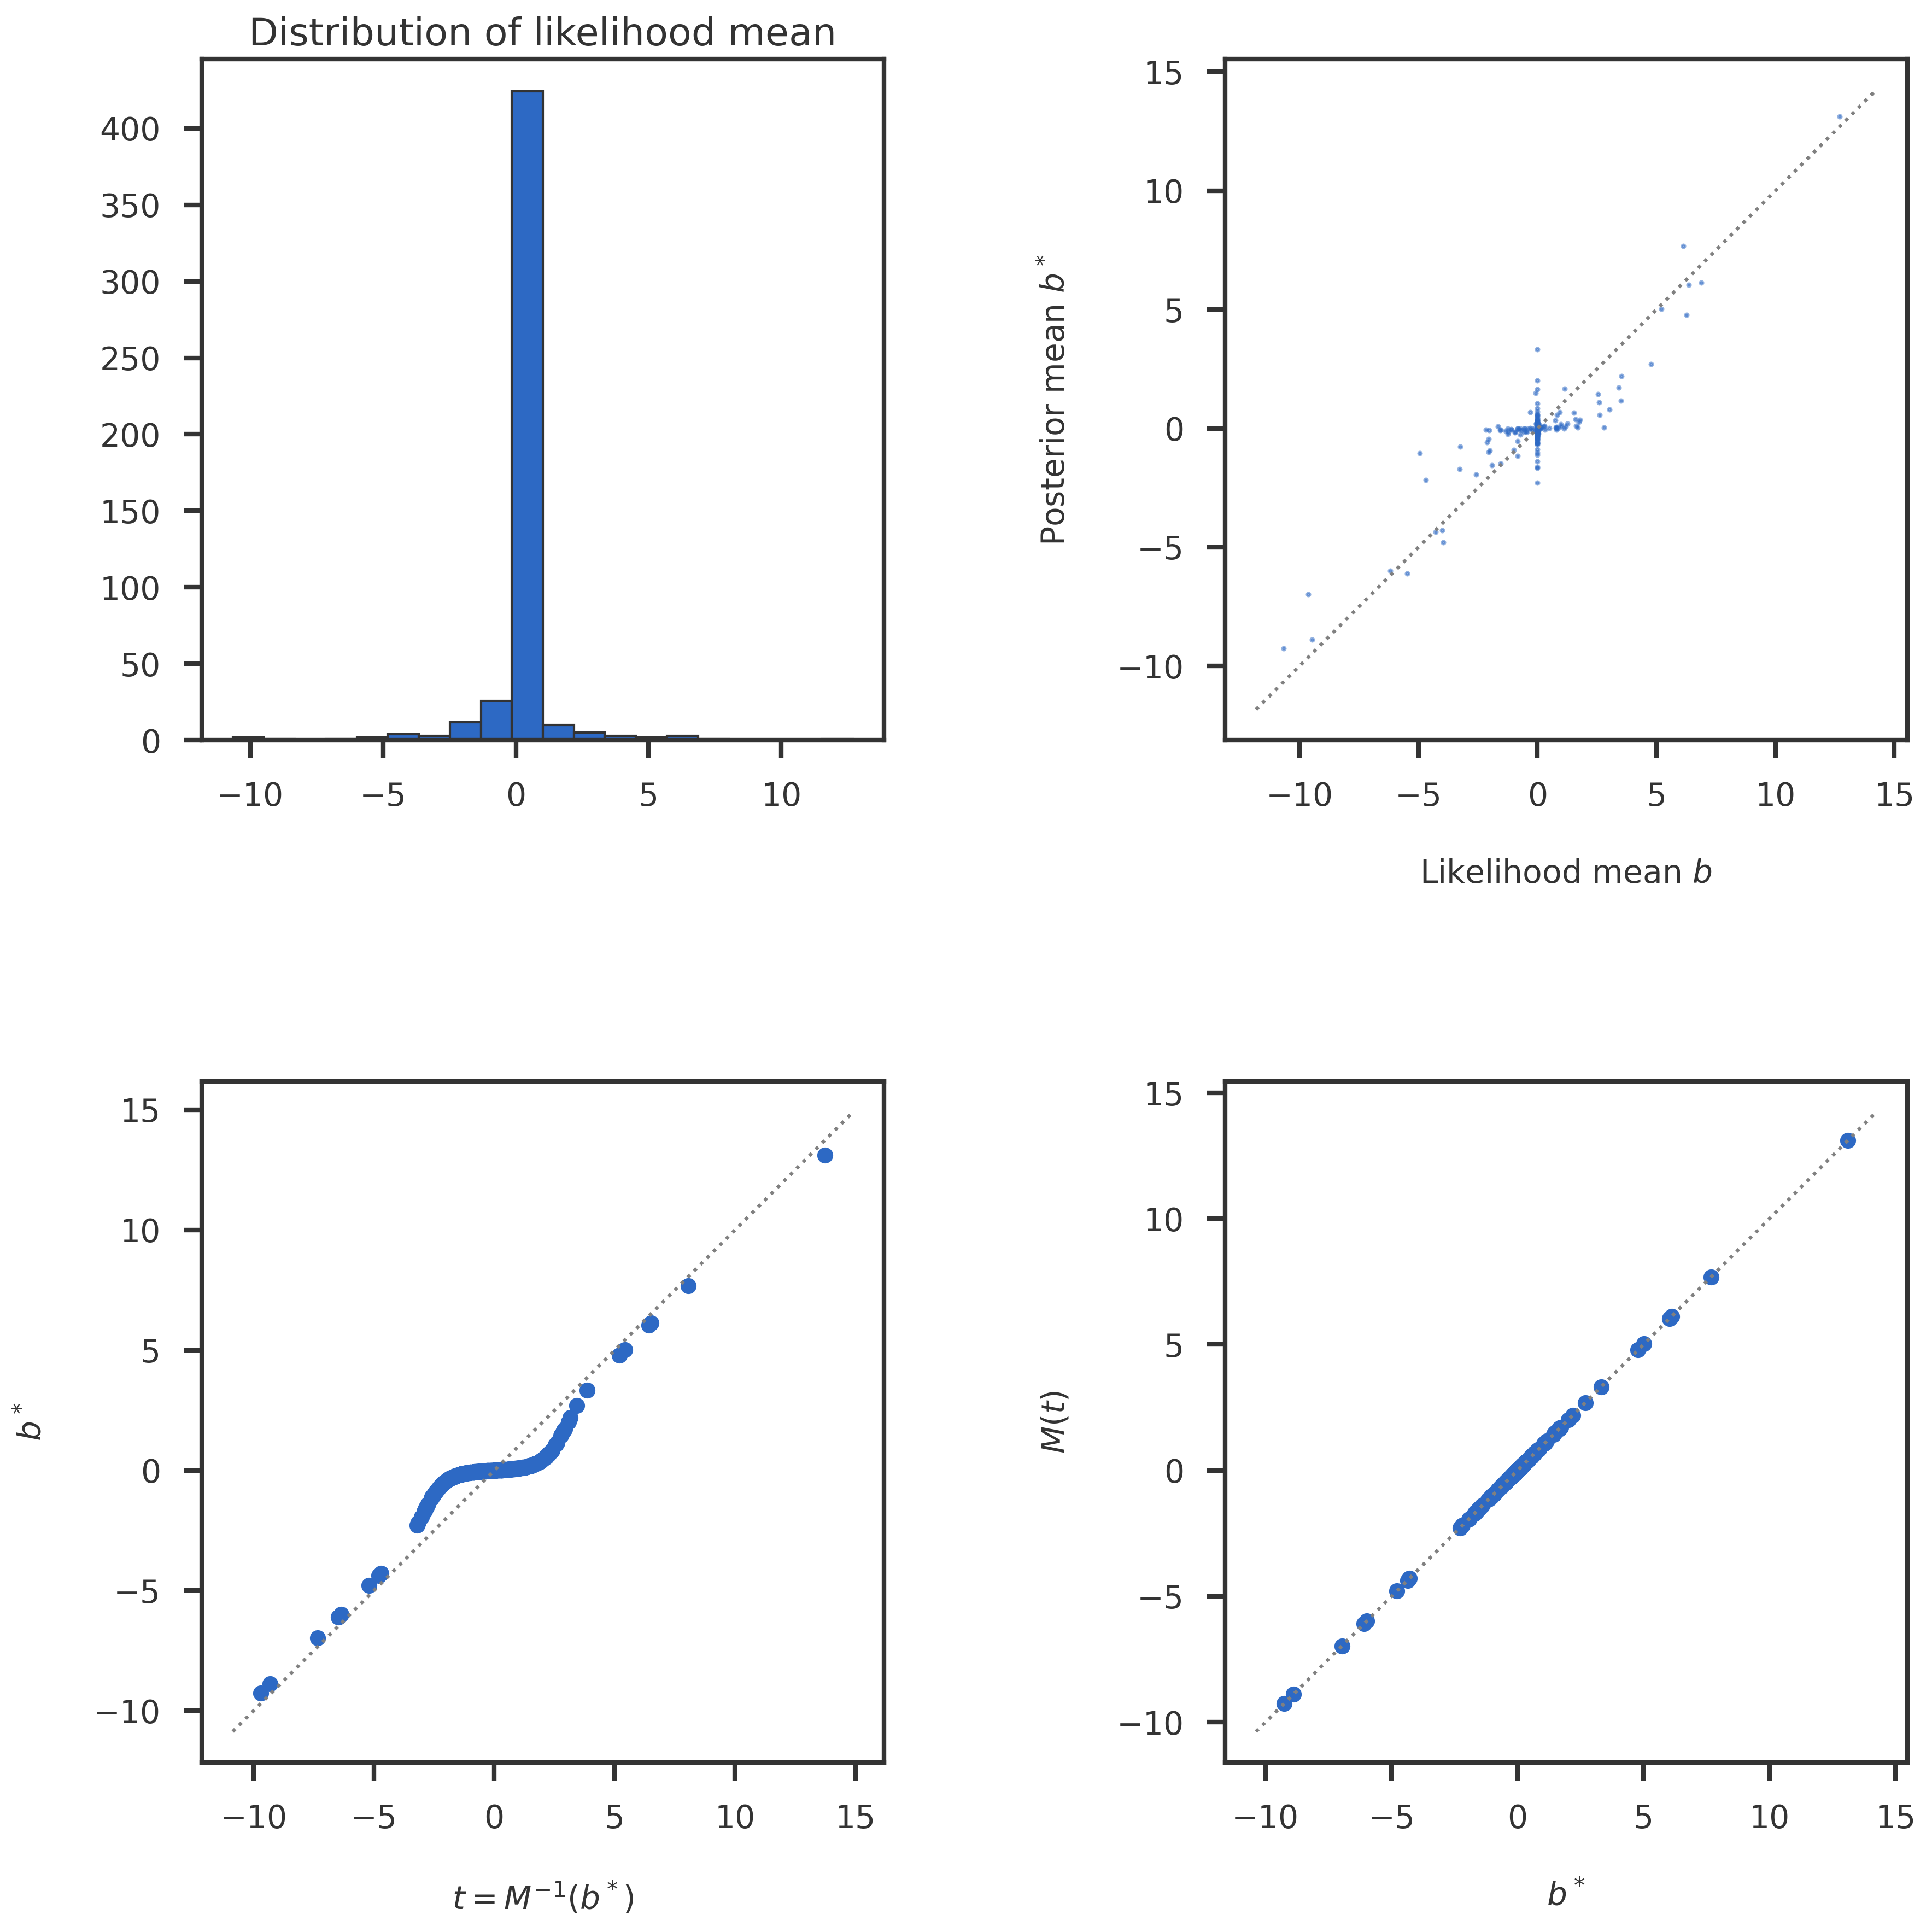

In [6]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.hist(btrue)
ax1.set_title("Distribution of likelihood mean")

ax2.scatter(btrue, bpostmean, s=2, alpha = 0.5)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"Likelihood mean $b$")
ax2.set_ylabel(r"Posterior mean $b^*$")
#ax1.hist(mean)

#ax3.scatter(bconst, theta_newraph)
ax3.scatter(theta_newraph, bconst)
mpl_utils.plot_diag(ax3)
ax3.set_ylabel(r"$b^*$")
ax3.set_xlabel(r"$t = M^{-1}(b^*)$")

ax4.scatter(bconst, b_newraph)
mpl_utils.plot_diag(ax4)
ax4.set_xlabel(r"$b^*$")
#ax4.set_ylabel(r"$M(M^{-1}(b^*))$")
ax4.set_ylabel(r"$M(t)$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

In [7]:
np.log(wpost) / np.log(np.exp(1))

array([-0.22606056, -2.68729104, -2.68929829, -2.71301435])

In [8]:
np.log(np.exp(1))

1.0

In [11]:
def penalty_function(theta, ak, std, sk, dj, jac = True):
    '''
    rho(theta) = rho(M(t))
        where M(t) = theta, that is t = M^{-1}(theta)
    '''
    wk = lgopt.softmax(ak)
    Minv = lgopt.shrinkage_operator_inverse(theta, std, wk, sk, dj)
    t = Minv.x
    nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
    #rhoMtj = - nm.logML - 0.5 * nm.yvar * np.square(nm.logML_deriv)
    rhoMtj = - 0.5 * np.square(t - theta) / nm.yvar
    #rhoMtj = - nm.logML - 0.5 * np.square(t - theta) / nm.yvar
    rhoMt = np.sum(rhoMtj)
    if jac:
        H_thetagrad = (t - theta) / nm.yvar
        return rhoMt, H_thetagrad
    return rhoMt


# rhotheta = penalty_function(theta_newraph, wpost, strue, sk, dj)
# print (rhotheta)

def penalty_bjac(theta, ak, std, sk, dj):
    wk = lgopt.softmax(ak)
    Minv = lgopt.shrinkage_operator_inverse(theta, std, wk, sk, dj)
    t = Minv.x
    nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
    #Mt_tgrad = 1 + nm.yvar * nm.logML_deriv2
    H_thetagrad = t - theta# / Mt_tgrad
    return H_thetagrad

def penalty_ajac_01(theta, ak, std, sk, dj, softmax_base = np.exp(1)):
    wk = lgopt.softmax(ak)
    Minv = lgopt.shrinkage_operator_inverse(theta, std, wk, sk, dj)
    t = Minv.x
    nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
    v2_ld_ldwd = nm.yvar.reshape(-1, 1) * nm.logML_deriv.reshape(-1, 1) * nm.logML_deriv_wderiv
    H_wgrad = - nm.logML_wderiv - v2_ld_ldwd
    H_wgrad = np.sum(H_wgrad, axis = 0)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    H_agrad = np.sum(H_wgrad * akjac, axis = 1)
    return H_agrad


def penalty_ajac_02(theta, ak, std, sk, dj, softmax_base = np.exp(1)):
    k = ak.shape[0]
    wk = lgopt.softmax(ak)
    Minv = lgopt.shrinkage_operator_inverse(theta, std, wk, sk, dj)
    t = Minv.x
    nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
    dMdt = 1 + nm.yvar * nm.logML_deriv2
    #H_wgrad = - ((1 + (1 / dMdt)) * (t - theta)).reshape(-1, 1) * nm.logML_deriv_wderiv
    H_wgrad = - ((1 + (1 / dMdt)) * (t - theta)).reshape(-1, 1) * nm.logML_deriv_wderiv
    H_wgrad = np.sum(H_wgrad, axis = 0)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    H_agrad = np.sum(H_wgrad * akjac, axis = 1)
    return H_agrad


apost = np.log(wpost)
obj = penalty_function(bconst, apost, strue, sk, dj, jac = False)
deriv_analytic = penalty_ajac_02(bconst, apost, strue, sk, dj)
eps = 1e-8
deriv_numeric = np.zeros(k)
for indx in range(k):
    ak_eps = apost.copy()
    ak_eps[indx] += eps
    obj_eps = penalty_function(bconst, ak_eps, strue, sk, dj, jac = False)
    deriv_numeric[indx] = (obj_eps - obj) / eps
    print(obj_eps)
print(deriv_numeric)    
print(deriv_analytic)
# obj, deriv_analytic = penalty_function(theta_newraph, wpost, strue, sk, dj)
# tindx = 10
# eps = 1e-4
# deriv_numeric = np.zeros(p)
# for indx in range(tindx):
#     theta_eps = theta_newraph.copy()
#     theta_eps[indx] += eps
#     obj_eps = penalty_function(theta_eps, wpost, strue, sk, dj, jac = False)
#     deriv_numeric[indx] = (obj_eps - obj) / eps
# print(deriv_numeric[:tindx])
# print(deriv_analytic[:tindx])
print(obj)

-189.40413796310426
-189.40413607077417
-189.4041356672102
-189.40413587776317
[-156.83378649   32.3992225    72.75561984   51.70032296]
[ 217.61359011  -37.92138959 -101.87396903  -77.81823149]
-189.4041363947664


In [16]:
def myfunc(b, ak, std, sk, dj, jac = True, softmax_base = np.exp(1)):
    wk = lgopt.softmax(ak, base = softmax_base)
    k = ak.shape[0]
    p = b.shape[0]
    Minv = lgopt.shrinkage_operator_inverse(b, std, wk, sk, dj)
    t = Minv.x
    if jac:
        nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
        dMdw = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
        dMdt = 1 + nm.yvar * nm.logML_deriv2
        dtdw = dMdw / dMdt.reshape(-1, 1)
        return t, dtdw
    else:
        return t
    
Minvb, dtdw = myfunc(bconst, apost, strue, sk, dj)

In [18]:
dtdw.shape

(500, 4)

In [12]:
nm = NormalMeansASHScaled(theta_newraph, strue, wpost, sk, d = dj)
#t2 = (theta_newraph - bconst) * n
#dMdw = nm.logML_deriv_wderiv

In [47]:
(theta_newraph - bconst).reshape(-1, 1) * nm.logML_deriv_wderiv

array([[-0.46749908,  0.73070361,  2.73402809,  2.07209805],
       [-0.00914884,  0.03448638,  0.04605821,  0.02746243],
       [-0.27814752,  0.61160947,  1.57488191,  1.10438557],
       ...,
       [-0.16259947,  0.43935272,  0.89159609,  0.59139715],
       [-0.11561965,  0.34188742,  0.62250142,  0.40204179],
       [-0.04367932,  0.15082176,  0.22608873,  0.13895952]])

In [54]:
dMdt = 1 + nm.yvar * nm.logML_deriv2
implicit_fact = 1 + (1 / dMdt)
t2 = (theta_newraph - bconst).reshape(-1, 1) * nm.logML_deriv_wderiv * implicit_fact.reshape(-1, 1)
H_wgrad = - nm.logML_wderiv - t2
H_wgrad = np.sum(H_wgrad, axis = 0)
akjac = wpost.reshape(-1, 1) * (np.eye(k) - wpost)
H_agrad = np.sum(H_wgrad * akjac, axis = 1)
H_agrad

array([ 218.45022142,  -38.57741532, -102.33174327,  -77.54106283])

In [51]:
np.ones(p) + 1/dMdt

array([ 2.79977574, 14.84406848,  3.96930409,  4.82416222,  6.75641403,
       16.379036  , 12.04709589, 16.39043361, 14.77489447, 15.86326015,
       15.72017249,  7.14536823,  4.90426575,  7.93598921,  9.35903428,
        2.04675268, 14.5528898 ,  5.48394672, 16.63685767, 15.64618937,
       15.400243  , 13.36522592, 16.5745233 ,  9.32237221,  2.07843718,
        5.55187805, 16.35297309,  3.43044733,  4.92674571,  1.76231219,
        1.51088019,  9.81726914,  9.29842042, 16.36357834, 11.15271475,
        1.514851  ,  1.95821656,  7.37492025,  1.96843898, 16.39007001,
       16.5433721 , 15.99952942, 11.37989751,  2.61035398, 16.44797119,
        3.08703571, 14.59282586,  8.72168398, 11.59906251,  9.6651718 ,
        1.60740464,  1.54437241,  1.52702235,  4.09401611, 16.57234299,
        5.02099399, 12.90030469, 15.59959425,  1.76496661,  7.92714381,
        8.61854582,  1.97757128,  1.62475999, 11.42313877,  2.36302159,
        1.51491306, 16.64055409, 13.35010634, 15.39873668, 10.45

In [44]:
nm.logML_deriv_wderiv

array([[ 0.31204086, -0.48772157, -1.82487735, -1.38305996],
       [ 0.02697765, -0.10169179, -0.13581426, -0.08097991],
       [ 0.20883065, -0.45919088, -1.18240714, -0.82916273],
       ...,
       [-0.14282457,  0.38591985,  0.78316262,  0.51947305],
       [ 0.11392238, -0.33686859, -0.61336324, -0.39613991],
       [-0.06297649,  0.21745358,  0.32597289,  0.2003507 ]])

In [42]:
def penalty_operator(theta, ak, std, sk, dj, jac = True, softmax_base = np.exp(1)):
    '''
    Returns the penalty operator, defined as sum_j lambda_j = rho(M(b)) / vj^2
    Dimensions:
        lambdaj: vector of size P
        l_bgrad: vector of size P
        l_wgrad: vector of size K
        l_sgrad: vector of size P 
    Note: lambdaj to be summed outside this function for sum_j lambda_j
          l_sgrad to be summed outside this function for sum_j d/ds2 lambda_j
    '''
    wk = lgopt.softmax(ak, base = softmax_base)
    nm = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
    lambdaj = - nm.logML - 0.5 * nm.yvar * np.square(nm.logML_deriv)
    lsum    = np.sum(lambdaj)
    if jac:
        # Gradient with respect to b
        l_bgrad = - nm.logML_deriv  - nm.yvar * nm.logML_deriv * nm.logML_deriv2
        # Gradient with repect to w
        v2_ld_ldwd = nm.yvar.reshape(-1, 1) * nm.logML_deriv.reshape(-1, 1) * nm.logML_deriv_wderiv
        l_wgrad = - nm.logML_wderiv - v2_ld_ldwd
        l_wgrad = np.sum(l_wgrad, axis = 0)
        # Gradient with respect to a
        akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
        l_agrad = np.sum(l_wgrad * akjac, axis = 1)
        # Gradient with respect to sigma2
        v2_ld_lds2d = nm.yvar * nm.logML_deriv * nm.logML_deriv_s2deriv
        l_sgrad = - (nm.logML_s2deriv + v2_ld_lds2d + 0.5 * np.square(nm.logML_deriv) / dj)
        return lsum, l_bgrad, l_agrad, l_sgrad
    else:
        return lsum
    

obj, _, deriv_analytic, _ = penalty_operator(theta_newraph, apost, strue, sk, dj, jac = True)
eps = 1e-8
deriv_numeric = np.zeros(k)
for indx in range(k):
    ak_eps = apost.copy()
    ak_eps[indx] += eps
    obj_eps = penalty_operator(theta_newraph, ak_eps, strue, sk, dj, jac = False)
    deriv_numeric[indx] = (obj_eps - obj) / eps
    print(obj_eps)
print(deriv_numeric)    
print(deriv_analytic)
print(obj)

692.3918190271103
692.3918196752047
692.3918199130978
692.3918198905814
[-59.93882723   4.87061698  28.65992883  26.40828143]
[-59.93883018   4.87061878  28.65992644  26.40828496]
692.3918196264985


In [26]:
lgopt.softmax(apost)

array([0.79766979, 0.06806508, 0.06792859, 0.06633654])

In [27]:
ak_eps

array([-0.22606056, -2.68729104, -2.68929829, -2.71291435])

In [28]:
lgopt.softmax(ak_eps)

array([0.7976645 , 0.06806462, 0.06792814, 0.06634274])

In [8]:
def objective(params, X, y, std, wk, sk, dj, jac = True, softmax_base = np.exp(1)):
    n, p = X.shape
    theta = params[:p]
    #ak    = params[p:]
    #wk    = lgopt.softmax(ak, base = softmax_base)
    r = y - np.dot(X, theta)
    rTr = np.sum(np.square(r))
    rTX = np.dot(r.T, X)
    rhot, rhot_thetagrad = penalty_function(theta, wk, std, sk, dj)
    obj = 0.5 * rTr / np.square(std) + rhot
    obj_thetagrad = - rTX / np.square(std) + rhot_thetagrad
    #obj_wgrad = np.zeros(wk.shape[0])
    #obj_grad = np.concatenate((obj_thetagrad, obj_wgrad))
    return obj, obj_thetagrad

In [9]:
import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate
from mrashpen.utils import R_lasso
from mrashpen.inference.mrash_wrapR          import MrASHR


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid


n = 200
p = 500
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.5, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [10]:
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
strue = np.std(y - np.dot(X, btrue))
dj = np.sum(np.square(X), axis = 0)
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = np.square(strue))

R[write to console]: Loading required package: Matrix



Mr.ASH terminated at iteration 709.


In [11]:
mrash_r.coef

array([-1.47628749e-03, -1.11441015e-03,  5.83903196e-05, -1.33385020e-04,
       -1.00528886e-05,  5.76030525e-04,  3.74756266e-04,  1.45717962e-04,
       -4.49245486e-05,  1.11521070e-04,  4.11155234e-04, -5.06563118e-05,
        4.82484253e-04,  1.29988564e-04,  4.61458583e-04, -1.75254155e-05,
        4.37943654e-04,  9.60964717e-06,  5.30701591e-05,  3.43872143e-04,
        2.77572534e-05, -2.00861277e-04,  6.76760954e-05,  3.42235312e-04,
        4.58966314e-04, -9.76100145e-04,  5.05757724e-04, -1.87995149e-04,
       -1.65108008e-04, -2.41397866e-05,  1.57381250e-04, -8.67804513e-04,
        9.86536796e-04,  2.90753236e-03,  1.42476237e-05, -1.78256393e-04,
       -5.44925661e-04,  8.70128380e-05,  2.08719017e-04,  2.78971605e-04,
        2.90887426e-04,  1.66031536e-04,  2.19734070e-06, -1.45850299e-04,
        6.48730840e-04,  1.59360597e-03,  1.46122382e-04, -9.29867717e-05,
       -3.78141866e-03,  2.62994345e-04, -3.19816018e-03,  5.07209301e-04,
       -1.52907482e-04,  

In [12]:
opt_min = sp_optimize.minimize(objective, mrash_r.coef,
                               args = (X, y, strue, mrash_r.prior, sk, dj),
                               method = 'l-bfgs-b', jac = True,
                               #options = {'disp': True, 'maxiter': 10, 'return_all': True}
                               options = {'disp':True, 'maxiter': 50}
                              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          500     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.86648D+02    |proj g|=  1.56002D+00


 This problem is unconstrained.



At iterate    1    f= -1.86661D+02    |proj g|=  1.67198D+00

At iterate    2    f= -1.86666D+02    |proj g|=  1.43459D+00

At iterate    3    f= -1.86670D+02    |proj g|=  1.43601D+00

At iterate    4    f= -1.86675D+02    |proj g|=  1.46006D+00

At iterate    5    f= -1.86679D+02    |proj g|=  1.42150D+00

At iterate    6    f= -1.86686D+02    |proj g|=  1.28917D+00

At iterate    7    f= -1.86690D+02    |proj g|=  1.14848D+00

At iterate    8    f= -1.86694D+02    |proj g|=  1.04763D+00

At iterate    9    f= -1.86699D+02    |proj g|=  8.56652D-01

At iterate   10    f= -1.86701D+02    |proj g|=  7.93588D-01

At iterate   11    f= -1.86706D+02    |proj g|=  6.36231D-01

At iterate   12    f= -1.86707D+02    |proj g|=  1.49437D+00

At iterate   13    f= -1.86711D+02    |proj g|=  5.47285D-01

At iterate   14    f= -1.86713D+02    |proj g|=  5.35280D-01

At iterate   15    f= -1.86714D+02    |proj g|=  5.06958D-01

At iterate   16    f= -1.86716D+02    |proj g|=  4.84681D-01

At iter

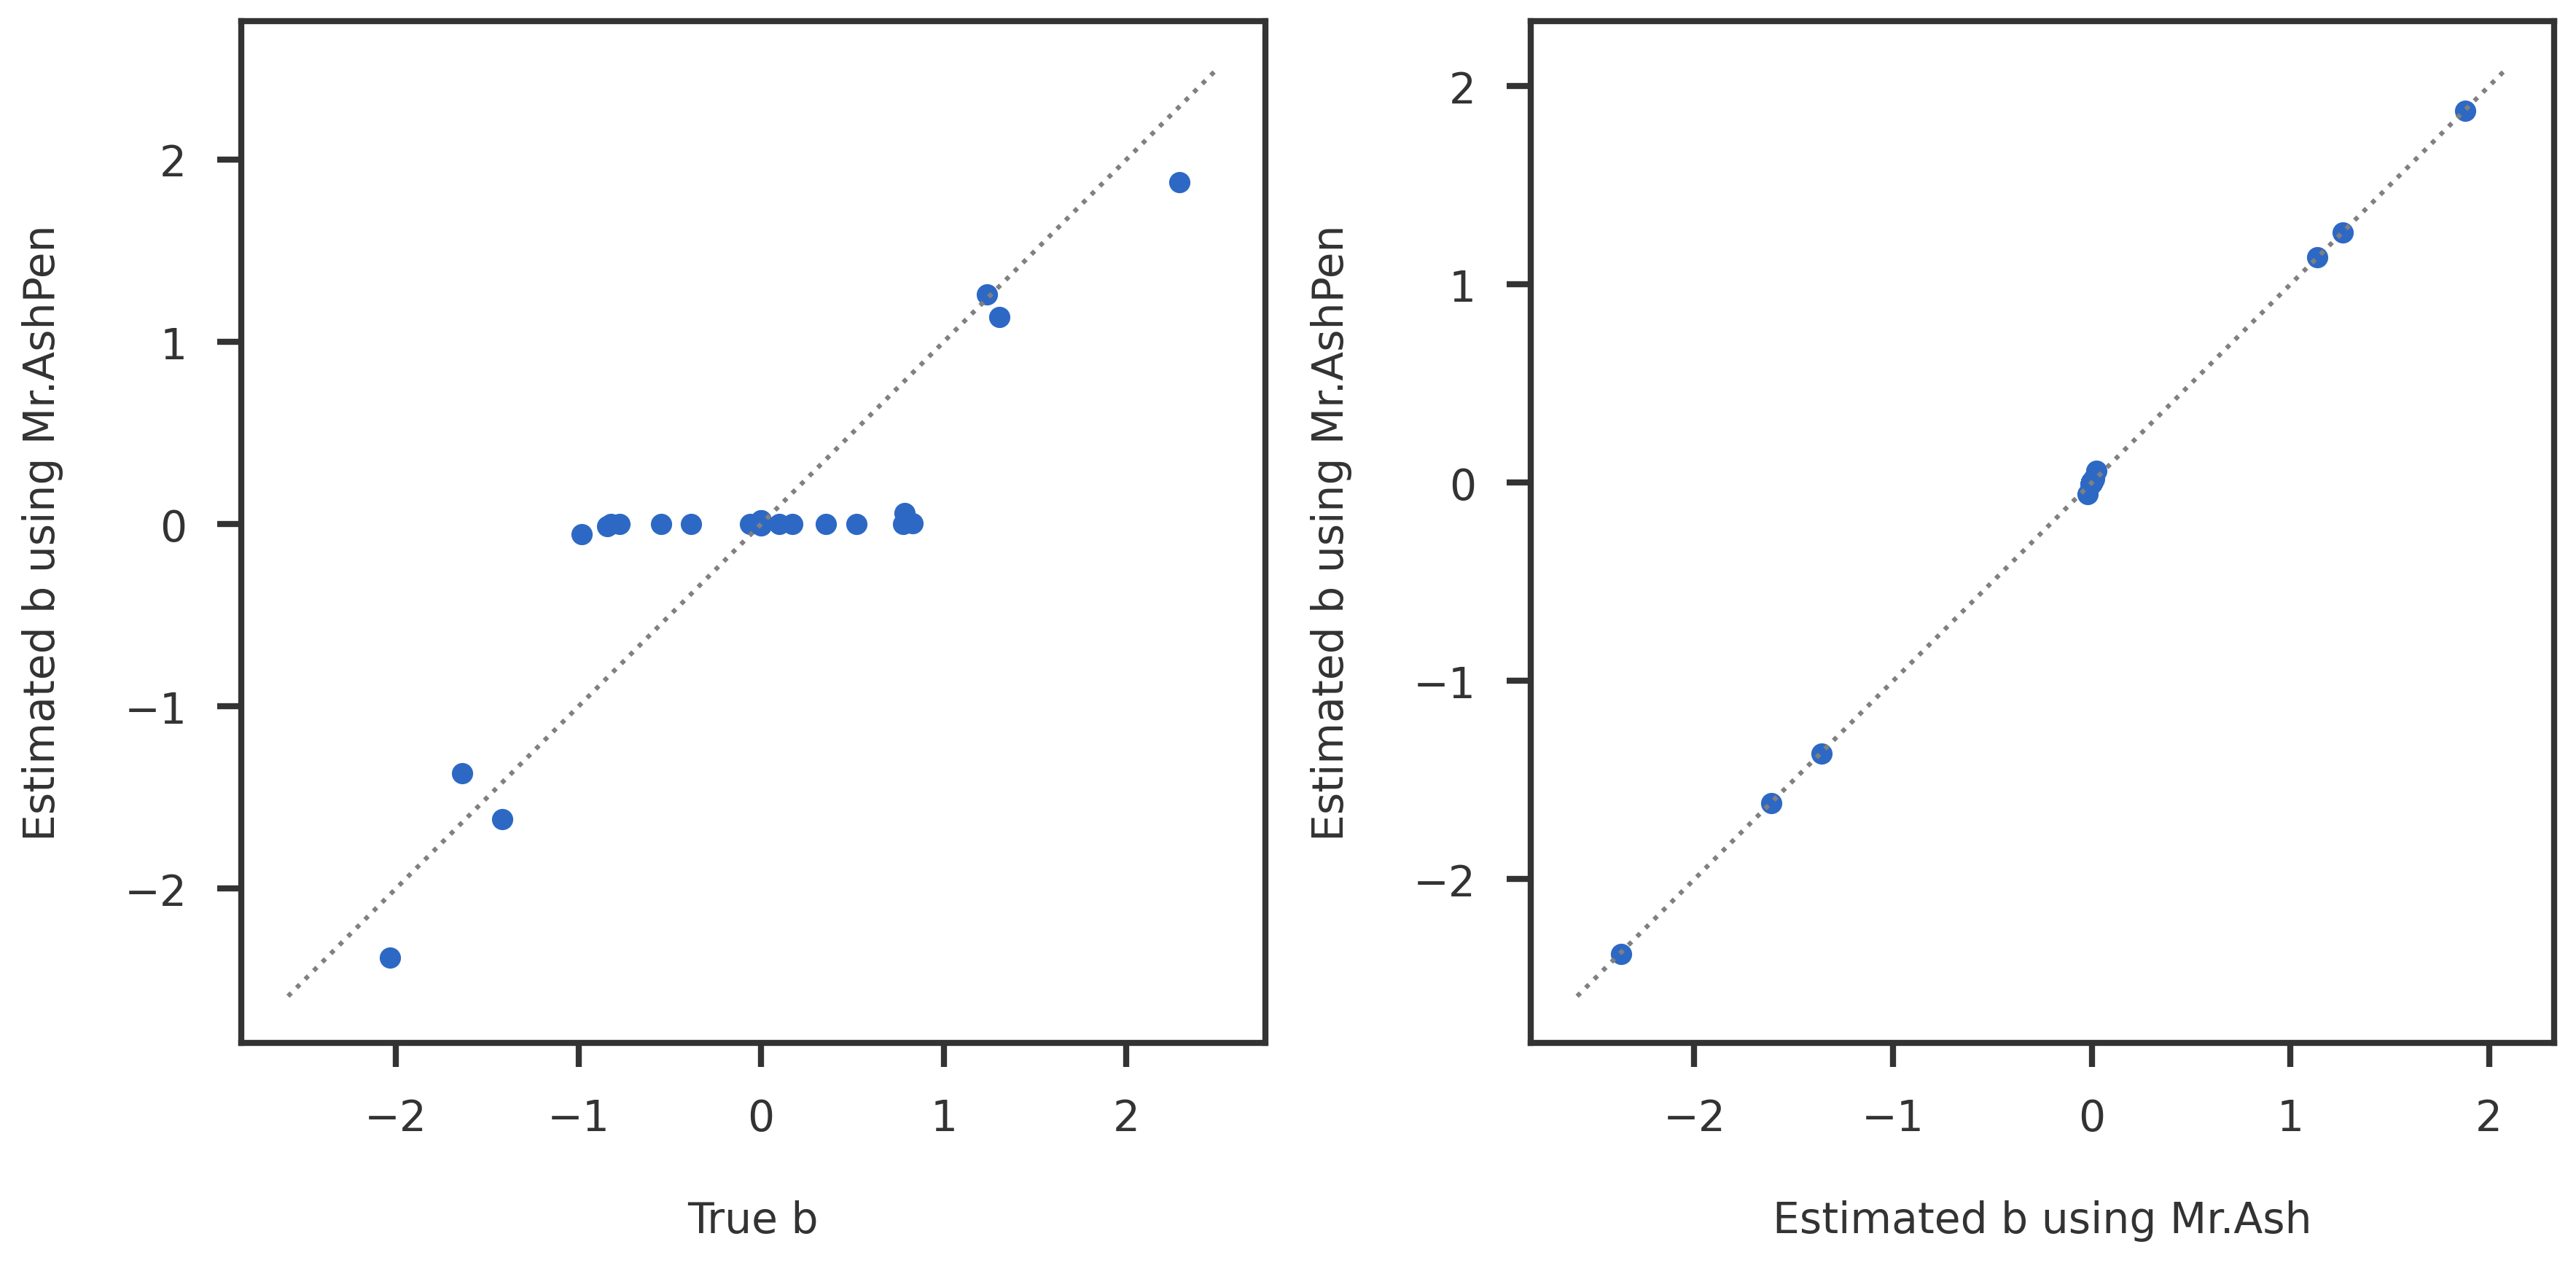

In [13]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(btrue, opt_min.x)
ax1.set_xlabel("True b")
ax1.set_ylabel("Estimated b using Mr.AshPen")
mpl_utils.plot_diag(ax1)

ax2.scatter(mrash_r.coef, opt_min.x)
ax2.set_xlabel("Estimated b using Mr.Ash")
ax2.set_ylabel("Estimated b using Mr.AshPen")
mpl_utils.plot_diag(ax2)

plt.tight_layout()
plt.show()